In [1]:
%matplotlib inline
import math

from matplotlib import pyplot as plt
from sklearn.cross_validation import KFold
from sklearn.mixture import GMM
import numpy
import numpy as np
import pandas as pd

In [2]:
def binary_transformation(df):
    df['Will_vote_only_large_party'] = df['Will_vote_only_large_party'].map(lambda x: 1 if x==1 else -1)
    df['Financial_agenda_matters'] = df['Financial_agenda_matters'].map(lambda x: 1 if x==1 else -1)


def dummis_transformation(df):
    dummies_df = pd.get_dummies(df['Most_Important_Issue'], prefix='Most_Important_Issue')
    df = pd.concat([df, dummies_df], axis=1, join='inner')
    return df.drop('Most_Important_Issue', axis=1)

df = pd.read_csv('./dataset/transformed_train.csv')
binary_transformation(df)
df=dummis_transformation(df)

cluster center: {'Yearly_ExpensesK': -0.17025761573597301, 'Most_Important_Issue_1.0': 0.0, 'Most_Important_Issue_4.0': 0.0, 'Most_Important_Issue_2.0': 0.0, 'Most_Important_Issue_0.0': 0.0, 'Avg_Residancy_Altitude': -0.088269896363512332, 'Yearly_IncomeK': -0.11895721040607564, 'Most_Important_Issue_7.0': 1.0, 'Most_Important_Issue_6.0': 0.0, 'Will_vote_only_large_party': 1.0, 'Financial_agenda_matters': -1.0, 'Most_Important_Issue_3.0': 0.0, 'Overall_happiness_score': 0.0019950224670613886, 'Most_Important_Issue_5.0': 0.0}
cluster size: 903


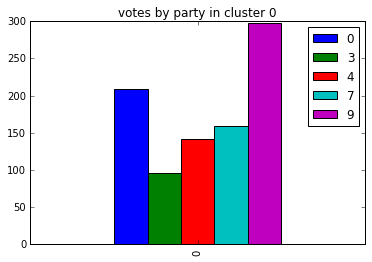

cluster center: {'Yearly_ExpensesK': 2.7206798699293175, 'Most_Important_Issue_1.0': 0.0, 'Most_Important_Issue_4.0': 0.0, 'Most_Important_Issue_2.0': 0.0, 'Most_Important_Issue_0.0': 0.0, 'Avg_Residancy_Altitude': 0.055961087573452112, 'Yearly_IncomeK': 2.9814891751176522, 'Most_Important_Issue_7.0': 0.0, 'Most_Important_Issue_6.0': 0.0, 'Will_vote_only_large_party': 0.99999999999999956, 'Financial_agenda_matters': 0.99999999999999956, 'Most_Important_Issue_3.0': 0.99999999999999956, 'Overall_happiness_score': 2.283012940818979, 'Most_Important_Issue_5.0': 0.0}
cluster size: 20


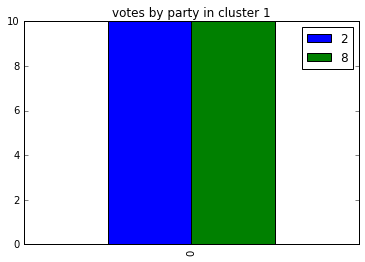

cluster center: {'Yearly_ExpensesK': -0.39426873176257393, 'Most_Important_Issue_1.0': 0.23255813953484114, 'Most_Important_Issue_4.0': 0.19999999999996337, 'Most_Important_Issue_2.0': 0.037209302325757677, 'Most_Important_Issue_0.0': 0.3069767441859903, 'Avg_Residancy_Altitude': 2.1342128670220215, 'Yearly_IncomeK': -0.35440890649585322, 'Most_Important_Issue_7.0': 0.22325581395344749, 'Most_Important_Issue_6.0': 0.0, 'Will_vote_only_large_party': -1.0, 'Financial_agenda_matters': -0.51627906976753046, 'Most_Important_Issue_3.0': 0.0, 'Overall_happiness_score': -0.76887548256239435, 'Most_Important_Issue_5.0': 0.0}
cluster size: 215


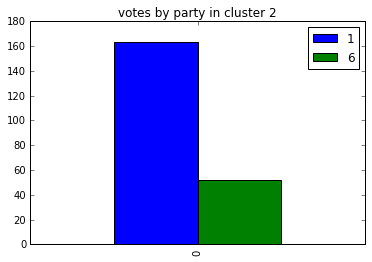

cluster center: {'Yearly_ExpensesK': 1.8858249004590588, 'Most_Important_Issue_1.0': 0.0, 'Most_Important_Issue_4.0': 0.0, 'Most_Important_Issue_2.0': 0.0, 'Most_Important_Issue_0.0': 0.0, 'Avg_Residancy_Altitude': -0.086288604350529874, 'Yearly_IncomeK': 2.3851785360729747, 'Most_Important_Issue_7.0': 0.0, 'Most_Important_Issue_6.0': 0.0, 'Will_vote_only_large_party': 1.0, 'Financial_agenda_matters': 1.0, 'Most_Important_Issue_3.0': 1.0, 'Overall_happiness_score': 1.1327076537320395, 'Most_Important_Issue_5.0': 0.0}
cluster size: 102


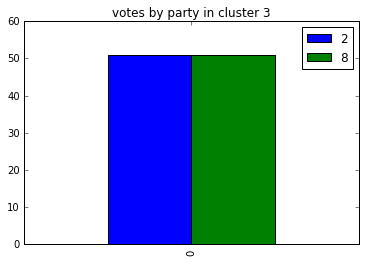

cluster center: {'Yearly_ExpensesK': -0.19043213865605269, 'Most_Important_Issue_1.0': 0.0, 'Most_Important_Issue_4.0': 0.0, 'Most_Important_Issue_2.0': 1.0, 'Most_Important_Issue_0.0': 0.0, 'Avg_Residancy_Altitude': -0.094316088799611605, 'Yearly_IncomeK': -0.11410192288393284, 'Most_Important_Issue_7.0': 0.0, 'Most_Important_Issue_6.0': 0.0, 'Will_vote_only_large_party': 1.0, 'Financial_agenda_matters': -1.0, 'Most_Important_Issue_3.0': 0.0, 'Overall_happiness_score': 0.017721762170749458, 'Most_Important_Issue_5.0': 0.0}
cluster size: 925


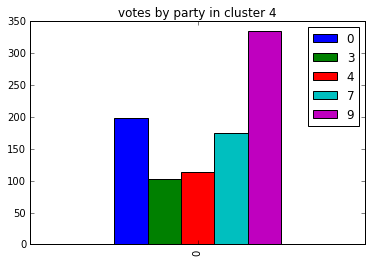

cluster center: {'Yearly_ExpensesK': 1.4185090013753696, 'Most_Important_Issue_1.0': 0.0, 'Most_Important_Issue_4.0': 0.0, 'Most_Important_Issue_2.0': 0.0, 'Most_Important_Issue_0.0': 0.0, 'Avg_Residancy_Altitude': -0.048680204105780195, 'Yearly_IncomeK': 0.38015891308383337, 'Most_Important_Issue_7.0': 0.0, 'Most_Important_Issue_6.0': 0.99999999999999989, 'Will_vote_only_large_party': 0.99999999999999989, 'Financial_agenda_matters': 0.99999999999999989, 'Most_Important_Issue_3.0': 0.0, 'Overall_happiness_score': -0.057576917764799014, 'Most_Important_Issue_5.0': 0.0}
cluster size: 347


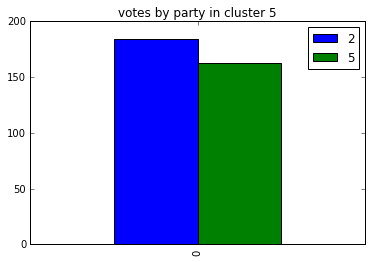

cluster center: {'Yearly_ExpensesK': -0.22712284605761907, 'Most_Important_Issue_1.0': 0.0, 'Most_Important_Issue_4.0': 0.99999999999999978, 'Most_Important_Issue_2.0': 0.0, 'Most_Important_Issue_0.0': 0.0, 'Avg_Residancy_Altitude': -0.069732002899268841, 'Yearly_IncomeK': -0.18323190808685247, 'Most_Important_Issue_7.0': 0.0, 'Most_Important_Issue_6.0': 0.0, 'Will_vote_only_large_party': 0.99999999999999978, 'Financial_agenda_matters': -0.99999999999999978, 'Most_Important_Issue_3.0': 0.0, 'Overall_happiness_score': 0.020702797625521796, 'Most_Important_Issue_5.0': 0.0}
cluster size: 935


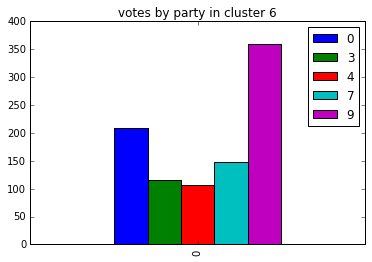

cluster center: {'Yearly_ExpensesK': -0.85960153152958929, 'Most_Important_Issue_1.0': 0.0, 'Most_Important_Issue_4.0': 0.0, 'Most_Important_Issue_2.0': 1.0, 'Most_Important_Issue_0.0': 0.0, 'Avg_Residancy_Altitude': 2.5828487230035408, 'Yearly_IncomeK': -0.84131088487417061, 'Most_Important_Issue_7.0': 0.0, 'Most_Important_Issue_6.0': 0.0, 'Will_vote_only_large_party': -1.0, 'Financial_agenda_matters': -1.0, 'Most_Important_Issue_3.0': 0.0, 'Overall_happiness_score': -0.45431442042585596, 'Most_Important_Issue_5.0': 0.0}
cluster size: 37


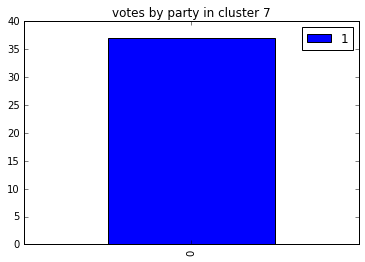

cluster center: {'Yearly_ExpensesK': -0.19278223338925457, 'Most_Important_Issue_1.0': 1.0, 'Most_Important_Issue_4.0': 0.0, 'Most_Important_Issue_2.0': 0.0, 'Most_Important_Issue_0.0': 0.0, 'Avg_Residancy_Altitude': -0.16449079693098193, 'Yearly_IncomeK': -0.13227261608581323, 'Most_Important_Issue_7.0': 0.0, 'Most_Important_Issue_6.0': 0.0, 'Will_vote_only_large_party': 1.0, 'Financial_agenda_matters': -1.0, 'Most_Important_Issue_3.0': 0.0, 'Overall_happiness_score': 0.00764978094040503, 'Most_Important_Issue_5.0': 0.0}
cluster size: 951


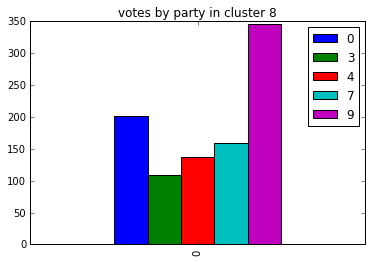

cluster center: {'Yearly_ExpensesK': -0.1667955589665284, 'Most_Important_Issue_1.0': 0.0, 'Most_Important_Issue_4.0': 0.0, 'Most_Important_Issue_2.0': 0.0, 'Most_Important_Issue_0.0': 1.0, 'Avg_Residancy_Altitude': -0.13359694150910437, 'Yearly_IncomeK': -0.099719549866681606, 'Most_Important_Issue_7.0': 0.0, 'Most_Important_Issue_6.0': 0.0, 'Will_vote_only_large_party': 1.0, 'Financial_agenda_matters': -1.0, 'Most_Important_Issue_3.0': 0.0, 'Overall_happiness_score': 0.043429301011160187, 'Most_Important_Issue_5.0': 0.0}
cluster size: 942


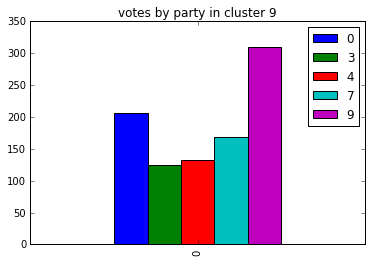

cluster center: {'Yearly_ExpensesK': 0.70032201007403216, 'Most_Important_Issue_1.0': 0.0, 'Most_Important_Issue_4.0': 0.0, 'Most_Important_Issue_2.0': 0.0, 'Most_Important_Issue_0.0': 0.0, 'Avg_Residancy_Altitude': -0.1310603358918655, 'Yearly_IncomeK': 0.60469002597211718, 'Most_Important_Issue_7.0': 0.0, 'Most_Important_Issue_6.0': 0.0, 'Will_vote_only_large_party': 1.0, 'Financial_agenda_matters': 1.0, 'Most_Important_Issue_3.0': 0.0, 'Overall_happiness_score': 0.53763235329468351, 'Most_Important_Issue_5.0': 1.0}
cluster size: 368


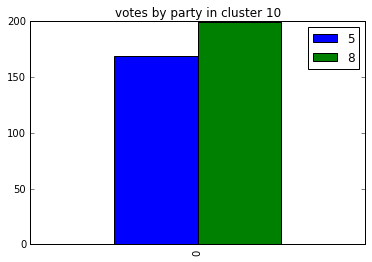

cluster center: {'Yearly_ExpensesK': 1.6895941770734177, 'Most_Important_Issue_1.0': 0.0, 'Most_Important_Issue_4.0': 1.0, 'Most_Important_Issue_2.0': 0.0, 'Most_Important_Issue_0.0': 0.0, 'Avg_Residancy_Altitude': -0.057373934389809797, 'Yearly_IncomeK': 1.7890520609896414, 'Most_Important_Issue_7.0': 0.0, 'Most_Important_Issue_6.0': 0.0, 'Will_vote_only_large_party': 1.0, 'Financial_agenda_matters': -1.0, 'Most_Important_Issue_3.0': 0.0, 'Overall_happiness_score': 0.051807080733244124, 'Most_Important_Issue_5.0': 0.0}
cluster size: 26


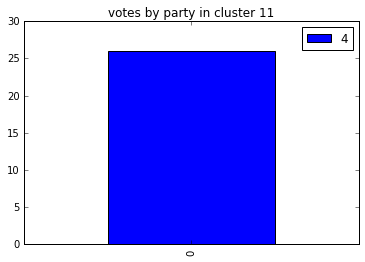

cluster center: {'Yearly_ExpensesK': 1.9567852196299955, 'Most_Important_Issue_1.0': 0.99999999999999778, 'Most_Important_Issue_4.0': 0.0, 'Most_Important_Issue_2.0': 0.0, 'Most_Important_Issue_0.0': 0.0, 'Avg_Residancy_Altitude': 1.6264969609799964, 'Yearly_IncomeK': 1.9987172694799955, 'Most_Important_Issue_7.0': 0.0, 'Most_Important_Issue_6.0': 0.0, 'Will_vote_only_large_party': 0.99999999999999778, 'Financial_agenda_matters': -0.99999999999999778, 'Most_Important_Issue_3.0': 0.0, 'Overall_happiness_score': 0.12303982184499972, 'Most_Important_Issue_5.0': 0.0}
cluster size: 1


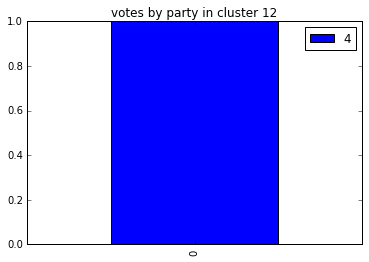

cluster center: {'Yearly_ExpensesK': -0.091731738237540425, 'Most_Important_Issue_1.0': 0.0, 'Most_Important_Issue_4.0': 0.0, 'Most_Important_Issue_2.0': 0.0, 'Most_Important_Issue_0.0': 0.0, 'Avg_Residancy_Altitude': -0.039523696194347063, 'Yearly_IncomeK': 0.36155114511584241, 'Most_Important_Issue_7.0': 0.0, 'Most_Important_Issue_6.0': 0.0, 'Will_vote_only_large_party': 0.99999999999999956, 'Financial_agenda_matters': 0.99999999999999956, 'Most_Important_Issue_3.0': 0.99999999999999956, 'Overall_happiness_score': -0.80884528936058886, 'Most_Important_Issue_5.0': 0.0}
cluster size: 228


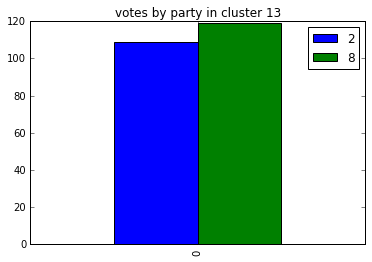

In [3]:
def get_votes_count_by_party(df):
    parties = {}
    for party in df.Vote.unique():
        parties[party] = len(df[df.Vote == party])
    return parties

def plot_clusters(gmm, df):
    df_no_vote = df.drop('Vote', axis=1)
    y_train_pred = gmm.fit_predict(df_no_vote)
    for v in xrange(gmm.n_components):
        cluster = df.iloc[[x for x, y in enumerate(y_train_pred) if y==v]]
        votes_by_party = pd.DataFrame(data=get_votes_count_by_party(cluster), index=[0])    
        votes_by_party.plot(kind='bar', title='votes by party in cluster ' + str(v))        
        print 'cluster center: ' + str({df_no_vote.columns[i]: gmm.means_[v][i] for i in xrange(len(df_no_vote.columns))})
        print 'cluster size: ' + str(len(cluster))
        plt.show()
    
gmm_14 = GMM(n_components=14, covariance_type="diag")
plot_clusters(gmm_14, df)

In [4]:
coalition_clusters = [0,2,4,5,8,13]
for c in coalition_clusters:
    print gmm_14.means_[c]
print gmm_14.means_[10]

[-0.17025762 -0.0882699   0.00199502  1.         -1.         -0.11895721
  0.          0.          0.          0.          0.          0.          0.
  1.        ]
[-0.39426873  2.13421287 -0.76887548 -1.         -0.51627907 -0.35440891
  0.30697674  0.23255814  0.0372093   0.          0.2         0.          0.
  0.22325581]
[-0.19043214 -0.09431609  0.01772176  1.         -1.         -0.11410192
  0.          0.          1.          0.          0.          0.          0.
  0.        ]
[ 1.418509   -0.0486802  -0.05757692  1.          1.          0.38015891
  0.          0.          0.          0.          0.          0.          1.
  0.        ]
[-0.19278223 -0.1644908   0.00764978  1.         -1.         -0.13227262
  0.          1.          0.          0.          0.          0.          0.
  0.        ]
[-0.09173174 -0.0395237  -0.80884529  1.          1.          0.36155115
  0.          0.          0.          1.          0.          0.          0.
  0.        ]
[ 0.70032201 -0.

In [5]:
df.columns

Index([u'Yearly_ExpensesK', u'Avg_Residancy_Altitude',
       u'Overall_happiness_score', u'Will_vote_only_large_party',
       u'Financial_agenda_matters', u'Yearly_IncomeK', u'Vote',
       u'Most_Important_Issue_0.0', u'Most_Important_Issue_1.0',
       u'Most_Important_Issue_2.0', u'Most_Important_Issue_3.0',
       u'Most_Important_Issue_4.0', u'Most_Important_Issue_5.0',
       u'Most_Important_Issue_6.0', u'Most_Important_Issue_7.0'],
      dtype='object')

cluster center: {'Yearly_ExpensesK': 1.6895941770734177, 'Most_Important_Issue_1.0': 0.0, 'Most_Important_Issue_4.0': 1.0, 'Most_Important_Issue_2.0': 0.0, 'Most_Important_Issue_0.0': 0.0, 'Avg_Residancy_Altitude': -0.057373934389809797, 'Yearly_IncomeK': 1.7890520609896414, 'Most_Important_Issue_7.0': 0.0, 'Most_Important_Issue_6.0': 0.0, 'Will_vote_only_large_party': 1.0, 'Financial_agenda_matters': -1.0, 'Most_Important_Issue_3.0': 0.0, 'Overall_happiness_score': 0.051807080733244124, 'Most_Important_Issue_5.0': 0.0}
cluster size: 26


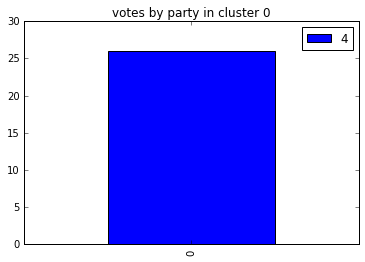

cluster center: {'Yearly_ExpensesK': -0.4625914047441661, 'Most_Important_Issue_1.0': 0.1984126984126984, 'Most_Important_Issue_4.0': 0.17063492063492064, 'Most_Important_Issue_2.0': 0.17857142857142855, 'Most_Important_Issue_0.0': 0.26190476190476186, 'Avg_Residancy_Altitude': 2.2000840046065395, 'Yearly_IncomeK': -0.42589848268624442, 'Most_Important_Issue_7.0': 0.19047619047619047, 'Most_Important_Issue_6.0': 0.0, 'Will_vote_only_large_party': -1.0, 'Financial_agenda_matters': -0.58730158730158721, 'Most_Important_Issue_3.0': 0.0, 'Overall_happiness_score': -0.72268992978842783, 'Most_Important_Issue_5.0': 0.0}
cluster size: 252


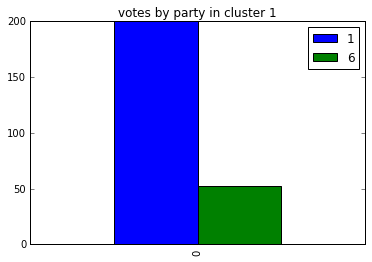

cluster center: {'Yearly_ExpensesK': 2.2538164104481808, 'Most_Important_Issue_1.0': 0.0, 'Most_Important_Issue_4.0': 0.0, 'Most_Important_Issue_2.0': 0.0, 'Most_Important_Issue_0.0': 0.0, 'Avg_Residancy_Altitude': 0.0049897501549111701, 'Yearly_IncomeK': 2.6863930984402136, 'Most_Important_Issue_7.0': 0.0, 'Most_Important_Issue_6.0': 0.0, 'Will_vote_only_large_party': 0.99999999999999967, 'Financial_agenda_matters': 0.99999999999999967, 'Most_Important_Issue_3.0': 0.99999999999999967, 'Overall_happiness_score': 1.6295214311333457, 'Most_Important_Issue_5.0': 0.0}
cluster size: 84


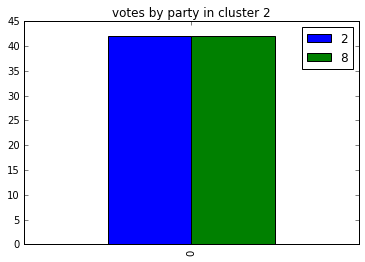

cluster center: {'Yearly_ExpensesK': 1.4185090013753696, 'Most_Important_Issue_1.0': 0.0, 'Most_Important_Issue_4.0': 0.0, 'Most_Important_Issue_2.0': 0.0, 'Most_Important_Issue_0.0': 0.0, 'Avg_Residancy_Altitude': -0.048680204105780195, 'Yearly_IncomeK': 0.38015891308383337, 'Most_Important_Issue_7.0': 0.0, 'Most_Important_Issue_6.0': 0.99999999999999989, 'Will_vote_only_large_party': 0.99999999999999989, 'Financial_agenda_matters': 0.99999999999999989, 'Most_Important_Issue_3.0': 0.0, 'Overall_happiness_score': -0.057576917764799014, 'Most_Important_Issue_5.0': 0.0}
cluster size: 347


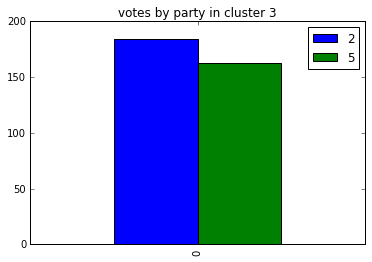

cluster center: {'Yearly_ExpensesK': -0.19267416503178866, 'Most_Important_Issue_1.0': 0.0, 'Most_Important_Issue_4.0': 0.0, 'Most_Important_Issue_2.0': 0.99999999999999989, 'Most_Important_Issue_0.0': 0.0, 'Avg_Residancy_Altitude': -0.095637465001629646, 'Yearly_IncomeK': -0.11648177111164923, 'Most_Important_Issue_7.0': 0.0, 'Most_Important_Issue_6.0': 0.0, 'Will_vote_only_large_party': 0.99999999999999989, 'Financial_agenda_matters': -0.99999999999999989, 'Most_Important_Issue_3.0': 0.0, 'Overall_happiness_score': 0.017441614933735573, 'Most_Important_Issue_5.0': 0.0}
cluster size: 924


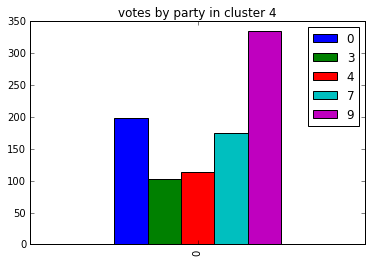

cluster center: {'Yearly_ExpensesK': -0.2518338122156788, 'Most_Important_Issue_1.0': 0.99999999999999967, 'Most_Important_Issue_4.0': 0.0, 'Most_Important_Issue_2.0': 0.0, 'Most_Important_Issue_0.0': 0.0, 'Avg_Residancy_Altitude': -0.16208441194093276, 'Yearly_IncomeK': -0.19275315219928299, 'Most_Important_Issue_7.0': 0.0, 'Most_Important_Issue_6.0': 0.0, 'Will_vote_only_large_party': 0.99999999999999967, 'Financial_agenda_matters': -0.99999999999999967, 'Most_Important_Issue_3.0': 0.0, 'Overall_happiness_score': 0.0077395563871783535, 'Most_Important_Issue_5.0': 0.0}
cluster size: 922


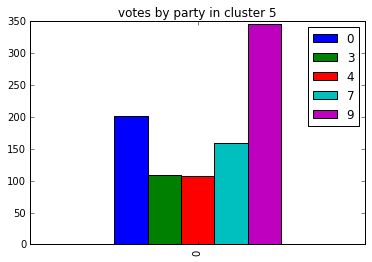

cluster center: {'Yearly_ExpensesK': 1.6928666567781232, 'Most_Important_Issue_1.0': 0.99999999999999989, 'Most_Important_Issue_4.0': 0.0, 'Most_Important_Issue_2.0': 0.0, 'Most_Important_Issue_0.0': 0.0, 'Avg_Residancy_Altitude': -0.17874011242601201, 'Yearly_IncomeK': 1.7966539819601439, 'Most_Important_Issue_7.0': 0.0, 'Most_Important_Issue_6.0': 0.0, 'Will_vote_only_large_party': 0.99999999999999989, 'Financial_agenda_matters': -0.99999999999999989, 'Most_Important_Issue_3.0': 0.0, 'Overall_happiness_score': 0.0087365784483312506, 'Most_Important_Issue_5.0': 0.0}
cluster size: 30


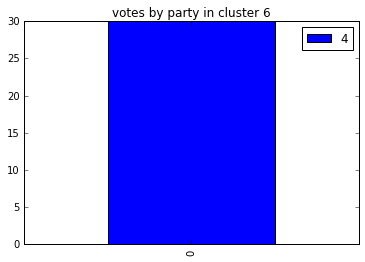

cluster center: {'Yearly_ExpensesK': 2.0585833104835358, 'Most_Important_Issue_1.0': 0.0, 'Most_Important_Issue_4.0': 0.0, 'Most_Important_Issue_2.0': 0.0, 'Most_Important_Issue_0.0': 0.0, 'Avg_Residancy_Altitude': -0.16432645150150302, 'Yearly_IncomeK': 1.8378032320172679, 'Most_Important_Issue_7.0': 0.0, 'Most_Important_Issue_6.0': 0.0, 'Will_vote_only_large_party': 0.99999999999999922, 'Financial_agenda_matters': 0.99999999999999922, 'Most_Important_Issue_3.0': 0.0, 'Overall_happiness_score': 1.848124668763591, 'Most_Important_Issue_5.0': 0.99999999999999922}
cluster size: 145


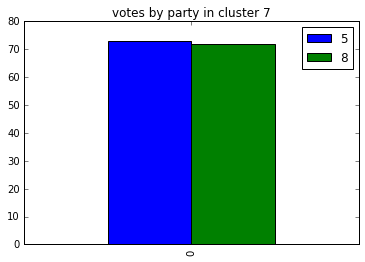

cluster center: {'Yearly_ExpensesK': 0.12008860341591959, 'Most_Important_Issue_1.0': 0.0, 'Most_Important_Issue_4.0': 0.0, 'Most_Important_Issue_2.0': 0.0, 'Most_Important_Issue_0.0': 0.0, 'Avg_Residancy_Altitude': -0.063138582974136298, 'Yearly_IncomeK': 0.58225734941840079, 'Most_Important_Issue_7.0': 0.0, 'Most_Important_Issue_6.0': 0.0, 'Will_vote_only_large_party': 1.0000000000000004, 'Financial_agenda_matters': 1.0000000000000004, 'Most_Important_Issue_3.0': 1.0000000000000004, 'Overall_happiness_score': -0.61787061562854462, 'Most_Important_Issue_5.0': 0.0}
cluster size: 266


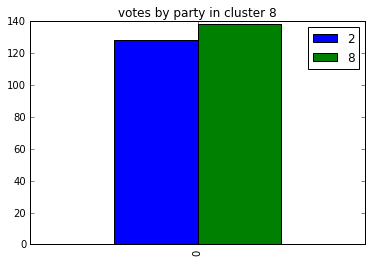

cluster center: {'Yearly_ExpensesK': -0.22712284605761907, 'Most_Important_Issue_1.0': 0.0, 'Most_Important_Issue_4.0': 0.99999999999999978, 'Most_Important_Issue_2.0': 0.0, 'Most_Important_Issue_0.0': 0.0, 'Avg_Residancy_Altitude': -0.069732002899268841, 'Yearly_IncomeK': -0.18323190808685247, 'Most_Important_Issue_7.0': 0.0, 'Most_Important_Issue_6.0': 0.0, 'Will_vote_only_large_party': 0.99999999999999978, 'Financial_agenda_matters': -0.99999999999999978, 'Most_Important_Issue_3.0': 0.0, 'Overall_happiness_score': 0.020702797625521796, 'Most_Important_Issue_5.0': 0.0}
cluster size: 935


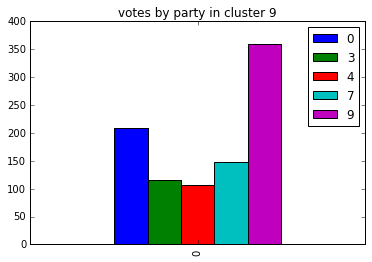

cluster center: {'Yearly_ExpensesK': -0.1667955589665284, 'Most_Important_Issue_1.0': 0.0, 'Most_Important_Issue_4.0': 0.0, 'Most_Important_Issue_2.0': 0.0, 'Most_Important_Issue_0.0': 1.0, 'Avg_Residancy_Altitude': -0.13359694150910437, 'Yearly_IncomeK': -0.099719549866681606, 'Most_Important_Issue_7.0': 0.0, 'Most_Important_Issue_6.0': 0.0, 'Will_vote_only_large_party': 1.0, 'Financial_agenda_matters': -1.0, 'Most_Important_Issue_3.0': 0.0, 'Overall_happiness_score': 0.043429301011160187, 'Most_Important_Issue_5.0': 0.0}
cluster size: 942


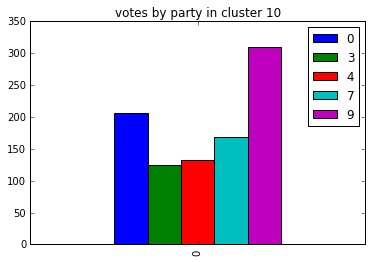

cluster center: {'Yearly_ExpensesK': 1.8812002342799958, 'Most_Important_Issue_1.0': 0.0, 'Most_Important_Issue_4.0': 0.0, 'Most_Important_Issue_2.0': 0.99999999999999778, 'Most_Important_Issue_0.0': 0.0, 'Avg_Residancy_Altitude': 1.1266355228999976, 'Yearly_IncomeK': 2.0848778413899955, 'Most_Important_Issue_7.0': 0.0, 'Most_Important_Issue_6.0': 0.0, 'Will_vote_only_large_party': 0.99999999999999778, 'Financial_agenda_matters': -0.99999999999999778, 'Most_Important_Issue_3.0': 0.0, 'Overall_happiness_score': 0.27657780939099941, 'Most_Important_Issue_5.0': 0.0}
cluster size: 1


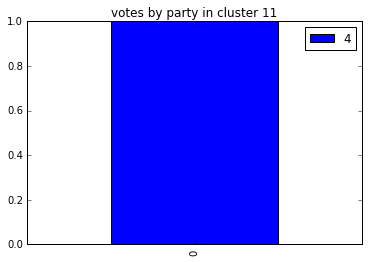

cluster center: {'Yearly_ExpensesK': -0.17025761573597298, 'Most_Important_Issue_1.0': 0.0, 'Most_Important_Issue_4.0': 0.0, 'Most_Important_Issue_2.0': 0.0, 'Most_Important_Issue_0.0': 0.0, 'Avg_Residancy_Altitude': -0.088269896363512346, 'Yearly_IncomeK': -0.11895721040607564, 'Most_Important_Issue_7.0': 1.0, 'Most_Important_Issue_6.0': 0.0, 'Will_vote_only_large_party': 1.0, 'Financial_agenda_matters': -1.0, 'Most_Important_Issue_3.0': 0.0, 'Overall_happiness_score': 0.0019950224670613878, 'Most_Important_Issue_5.0': 0.0}
cluster size: 903


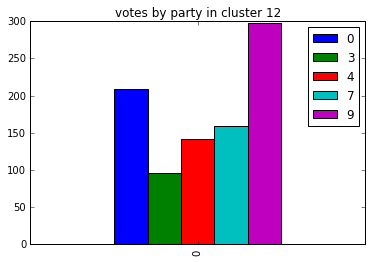

cluster center: {'Yearly_ExpensesK': -0.23586205266068824, 'Most_Important_Issue_1.0': 0.0, 'Most_Important_Issue_4.0': 0.0, 'Most_Important_Issue_2.0': 0.0, 'Most_Important_Issue_0.0': 0.0, 'Avg_Residancy_Altitude': -0.10813160542340271, 'Yearly_IncomeK': -0.24523548592985497, 'Most_Important_Issue_7.0': 0.0, 'Most_Important_Issue_6.0': 0.0, 'Will_vote_only_large_party': 1.0000000000000004, 'Financial_agenda_matters': 1.0000000000000004, 'Most_Important_Issue_3.0': 0.0, 'Overall_happiness_score': -0.36562685000325695, 'Most_Important_Issue_5.0': 1.0000000000000004}
cluster size: 223


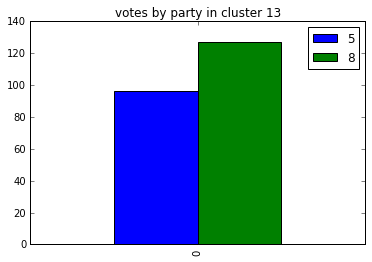

In [6]:
new_gmm = GMM(n_components=14, covariance_type="diag")
plot_clusters(new_gmm, df)

In [7]:
coalition_clusters = [0,7,8,10]
for c in coalition_clusters:
    print new_gmm.means_[c]
#print new_gmm.means_[0]

[ 1.68959418 -0.05737393  0.05180708  1.         -1.          1.78905206
  0.          0.          0.          0.          1.          0.          0.
  0.        ]
[ 2.05858331 -0.16432645  1.84812467  1.          1.          1.83780323
  0.          0.          0.          0.          0.          1.          0.
  0.        ]
[ 0.1200886  -0.06313858 -0.61787062  1.          1.          0.58225735
  0.          0.          0.          1.          0.          0.          0.
  0.        ]
[-0.16679556 -0.13359694  0.0434293   1.         -1.         -0.09971955
  1.          0.          0.          0.          0.          0.          0.
  0.        ]


In [52]:
_df = pd.read_csv('dataset/ElectionsData.csv')
_df.head()
f = 'Most_Important_Issue'
_df[f] = _df[f].astype("category")
_df[f + "Int"] = _df[f].cat.rename_categories(range(_df[f].nunique())).astype(int)
_df[[f, f + "Int"]]

for c in _df[f].unique():
    print c
    print _df[_df[f]==c][f + "Int"].head()
    
# {
#     0: Education,
#     1: Environment,
#     2: Financial,
#     3: Foreign_Affairs,
#     4: Healthcare,
#     5: Military,
#     6: Other,
#     7: Social
# }

Education
0     0
1     0
6     0
9     0
10    0
Name: Most_Important_IssueInt, dtype: int64
Foreign_Affairs
2     3
13    3
23    3
26    3
39    3
Name: Most_Important_IssueInt, dtype: int64
Financial
3     2
5     2
7     2
8     2
12    2
Name: Most_Important_IssueInt, dtype: int64
Healthcare
4     4
11    4
18    4
22    4
24    4
Name: Most_Important_IssueInt, dtype: int64
Environment
14    1
16    1
42    1
52    1
73    1
Name: Most_Important_IssueInt, dtype: int64
Military
17    5
35    5
36    5
38    5
40    5
Name: Most_Important_IssueInt, dtype: int64
Other
30    6
37    6
43    6
62    6
75    6
Name: Most_Important_IssueInt, dtype: int64
Social
32    7
54    7
60    7
65    7
69    7
Name: Most_Important_IssueInt, dtype: int64
nan
Series([], Name: Most_Important_IssueInt, dtype: int64)


In [71]:
d = pd.DataFrame([[1,2],[4,5]] , columns=['a', 'b'])

In [72]:
d

,a,b
0,1,2
1,4,5


In [59]:
d

,a,b


In [65]:
d.append({'a': 1, 'b':2})

TypeError: Can only append a Series if ignore_index=True or if the Series has a name

In [64]:
d


,a,b
